In [ ]:
import random
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
from PIL import Image
from torch.utils.data import DataLoader
from torchmetrics import MeanAbsoluteError, MeanSquaredError, R2Score
from tqdm.auto import tqdm


In [2]:
%load_ext autoreload
%autoreload 2

from src.model.CNN_regression import (
    DBHDepthDataset,
    DBHRegressor,
    evaluate,
    get_eval_transforms,
    train_one_epoch,
)


In [3]:
def load_model(backbone, checkpoint_path, device):
    model = DBHRegressor(backbone)
    state_dict = torch.load(checkpoint_path, map_location=device)

    # handle DataParallel checkpoints
    if any(k.startswith("module.") for k in state_dict.keys()):
        state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    return model

In [27]:
@torch.no_grad()
def visualize_random_test_samples(
    checkpoint_path: str,
    backbone: str,
    test_csv: str,
    base_path: str,
    k: int = 4,
    image_size: int = 192,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
):
    base_path = Path(base_path)
    df = pd.read_csv(test_csv)

    # sample k rows
    samples = df.sample(k)

    # load model once
    model = load_model(backbone, checkpoint_path, device)

    fig, axes = plt.subplots(k, 2, figsize=(10, 2 * k))

    # handle k = 1 edge case
    if k == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, (_, row) in enumerate(samples.iterrows()):
        rgb_path = base_path / "test" / row["image_path"]
        depth_path = base_path / row["depth_anything_maps_path"]
        gt_dbh = row["DBH"]

        # load RGB
        rgb = Image.open(rgb_path).convert("RGB")

        # load depth
        depth = np.load(depth_path).astype(np.float32)
        depth_norm = depth / 255.0  # MUST match training

        depth_tensor = (
            torch.from_numpy(depth_norm)
            .unsqueeze(0)
            .unsqueeze(0)
            .to(device)
        )

        # predict
        pred_dbh = model(depth_tensor).item()

        # plot RGB
        axes[i, 0].imshow(rgb)
        axes[i, 0].set_title("RGB Image")
        axes[i, 0].axis("off")

        # plot depth
        axes[i, 1].imshow(depth, cmap="gray")
        axes[i, 1].set_title(
            f"Depth Map\nGT: {gt_dbh:.2f} cm | Pred: {pred_dbh:.2f} cm"
        )
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()


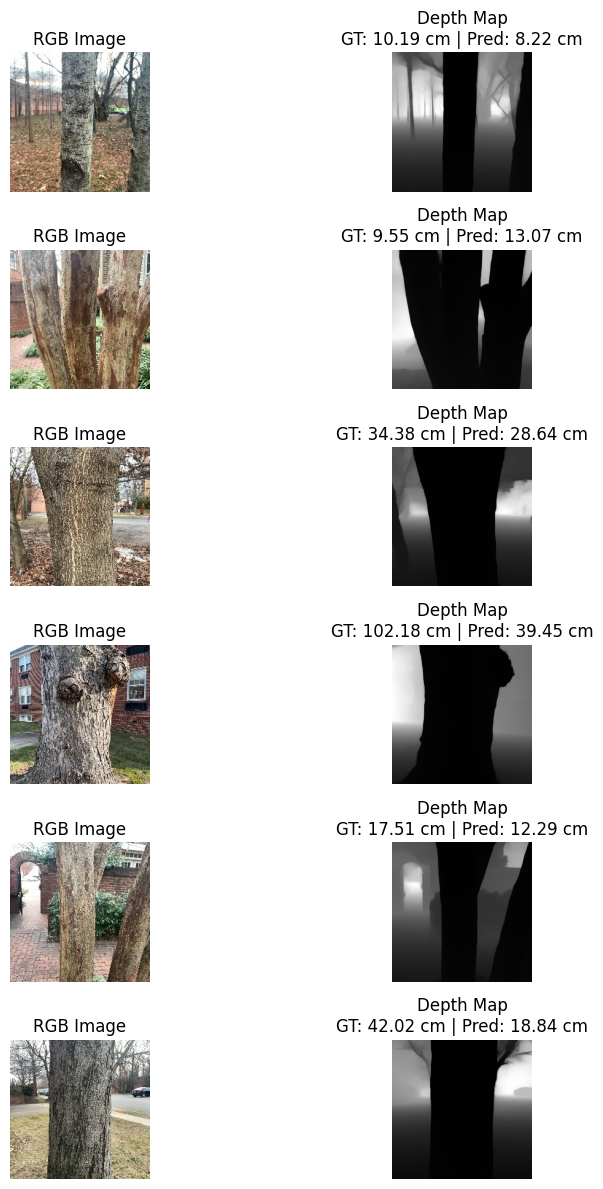

In [30]:
checkpoint = "../model/resnet50_depth_dbh_DA3_LARGE_20260209_1724_8_best.pt"
test_csv = "../dataset/DepthMapDBH2023/test/test/files_with_depth_maps_DA3_LARGE.csv"

visualize_random_test_samples(
    checkpoint_path=checkpoint,
    backbone="resnet50",
    test_csv=test_csv,
    base_path="../dataset/DepthMapDBH2023/",
    k=6,
)